# Consumer Price Index analysis

By Ben Welsh

A rudimentary analysis of the Consumer Price Index published by the U.S. Bureau of Labor Statistics. It was developed to verify the accuracy of the [cpi](https://github.com/datadesk/cpi) open-source Python wrapper that eases access to the official government data. 

### Import Python tools

In [1]:
import os
import copy
import pandas as pd
import altair as alt
from datetime import datetime, timedelta

### Import the development version of this library

In [2]:
import sys
this_dir = os.path.dirname(os.getcwd())
parent_dir = os.path.dirname(this_dir)
sys.path.insert(0, this_dir) 
sys.path.insert(0, parent_dir) 
import cpi

### Hack together a method to convert a CPI series to a pandas DataFrame

It would be great to bake this kind of feature into the library in the future.

In [3]:
def to_df(series):
    monthlies = sorted([i for i in series.indexes if i.period.type == 'monthly'], key=lambda x: x.date)
    df_list = []
    for m in monthlies:
        d = copy.deepcopy(m.__dict__())
        del d['series']
        del d['period']
        d['date'] = pd.to_datetime(m.date)
        df_list.append(d)
    return pd.DataFrame(df_list).sort_values("date")

### Match monthly analysis published by the BLS.

In a July 2018 [press release](https://www.bls.gov/news.release/pdf/cpi.pdf) the BLS published the following chart showing the month to month percentage change in the Consumer Price Index for All Urban Consumers, also known as the CPI-U. We will replicate it below.

![](https://i.imgur.com/zkLKG5B.png)

Query the seasonally-adjusted CPI-U, which is the variation used by the BLS in its release.

In [4]:
adjusted_cpiu = to_df(cpi.series.get_by_id('CUSR0000SA0'))

Calculate the monthly percentage change.

In [5]:
adjusted_cpiu['pct_change'] = (adjusted_cpiu.value.pct_change()*100)

Round it in the same manner as the BLS.

In [6]:
adjusted_cpiu['pct_change_rounded'] = adjusted_cpiu['pct_change'].round(1)

Trim down to the 13 most recent months of data.

In [7]:
last_13 = adjusted_cpiu.sort_values("date").tail(13)

Draw the chart.

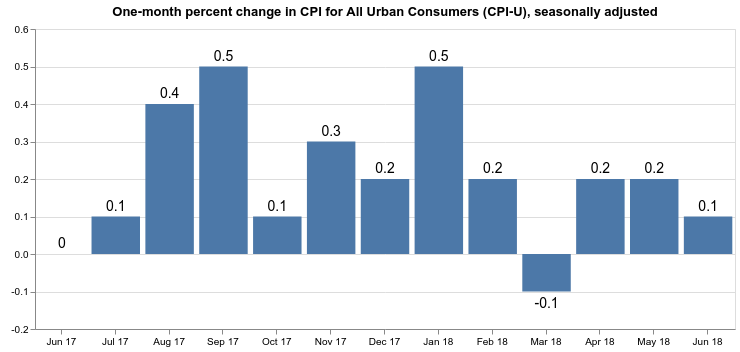

In [13]:
base = alt.Chart(
    last_13, 
    title="One-month percent change in CPI for All Urban Consumers (CPI-U), seasonally adjusted"
).properties(width=700)

bars = base.mark_bar().encode(
    x=alt.X(
        "date:O",
        timeUnit="yearmonth",
        axis=alt.Axis(title=None, labelAngle=0, format="%b %y"),
    ),
    y=alt.Y(
        "pct_change_rounded:Q",
        axis=alt.Axis(title=None),
        scale=alt.Scale(domain=[
            last_13['pct_change'].min()-0.1,
            last_13['pct_change'].max()+0.05
        ])
    )
)

text = base.encode(
    x=alt.X("date:O", timeUnit="yearmonth"),
    y="pct_change_rounded:Q",
    text='pct_change_rounded'
)

textAbove = text.transform_filter(alt.datum.pct_change > 0).mark_text(
    align='center',
    baseline='middle',
    fontSize=14,
    dy=-10
)

textBelow = text.transform_filter(alt.datum.pct_change < 0).mark_text(
    align='center',
    baseline='middle',
    fontSize=14,
    dy=12
)

bars + textAbove + textBelow

### Dump the file to JSON

In [9]:
last_13.to_json("./last_13.json")